# 1. Setup

In [1]:
import numpy as np
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = False

In [2]:
data_path = Path('./data')
model_path = Path('./models')

model_path.mkdir(parents=True, exist_ok=True)

In [3]:
# Load data
ts1 = pickle.load(open(data_path / 'time_series_1.pickle', 'rb'))
ts2 = pickle.load(open(data_path / 'time_series_2.pickle', 'rb'))
y = pickle.load(open(data_path / 'y.pickle', 'rb'))

In [4]:
# Merge the 2 input time series. This gives us (4000, 5000, 2), which corresponds to
# (n_sequences, n_timesteps, n_features) which is what is needed to train sequence
# models
X = np.stack([ts1, ts2], axis=2)
X.shape

(4000, 5000, 2)

# 2. Exploratory data analysis

## 2.1. Label distribution

In [5]:
np.unique(y, return_counts=True)

(array([0., 1., 2., 3.]), array([1000, 1000, 1000, 1000], dtype=int64))

It appears we have an even distribution of the labels here. Therefore, assuming we care equally about all turbine operating modes, accuracy can be considered a sensible evaluation metric.

## 2.2. Visualising the sensor data for each state

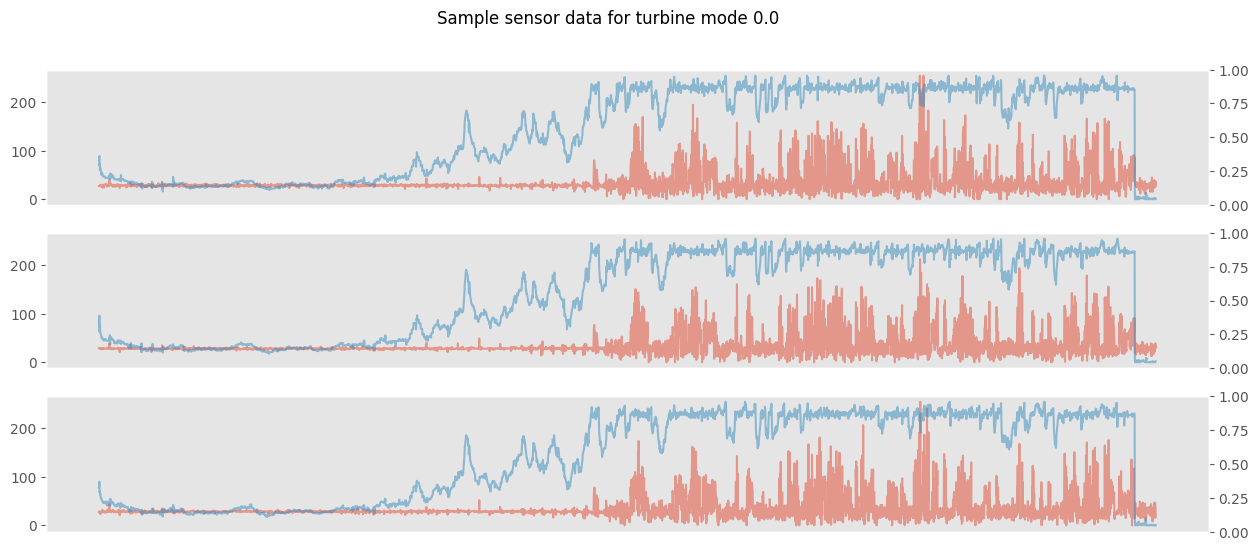

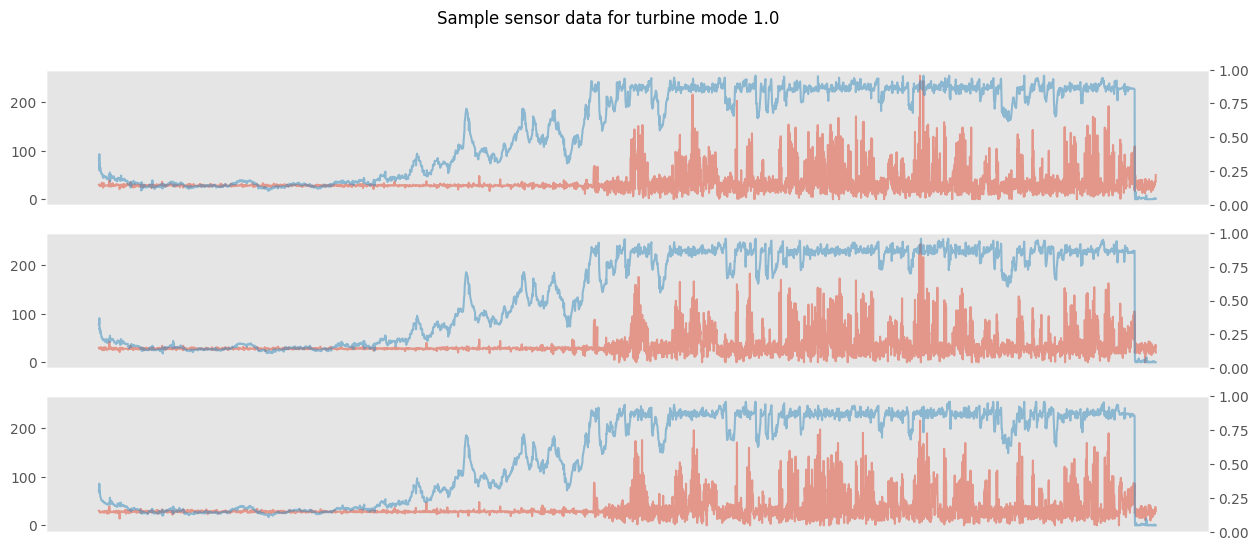

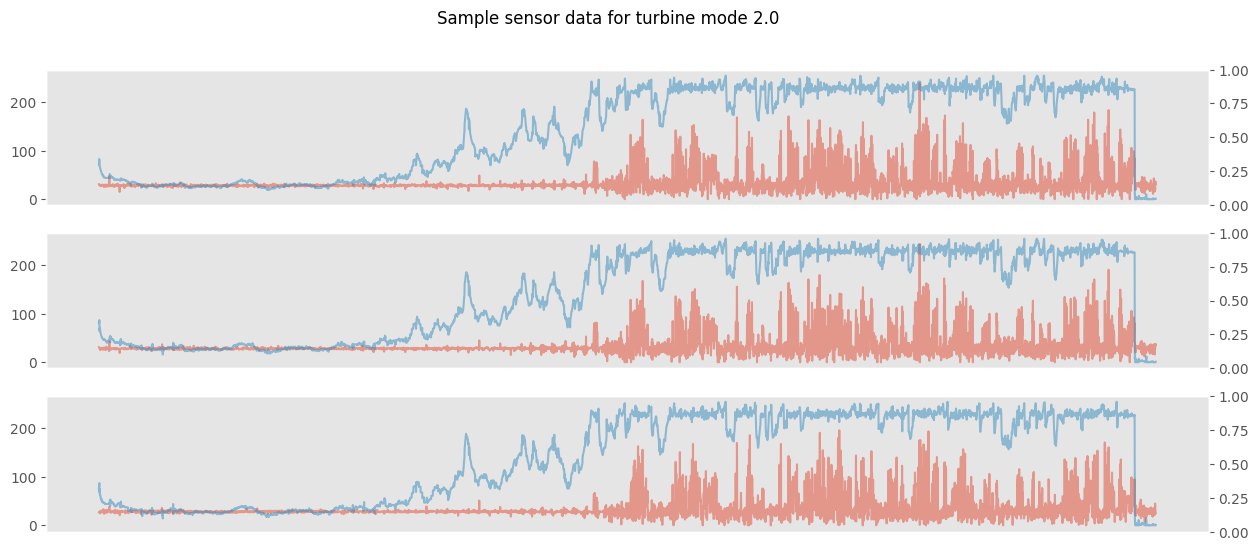

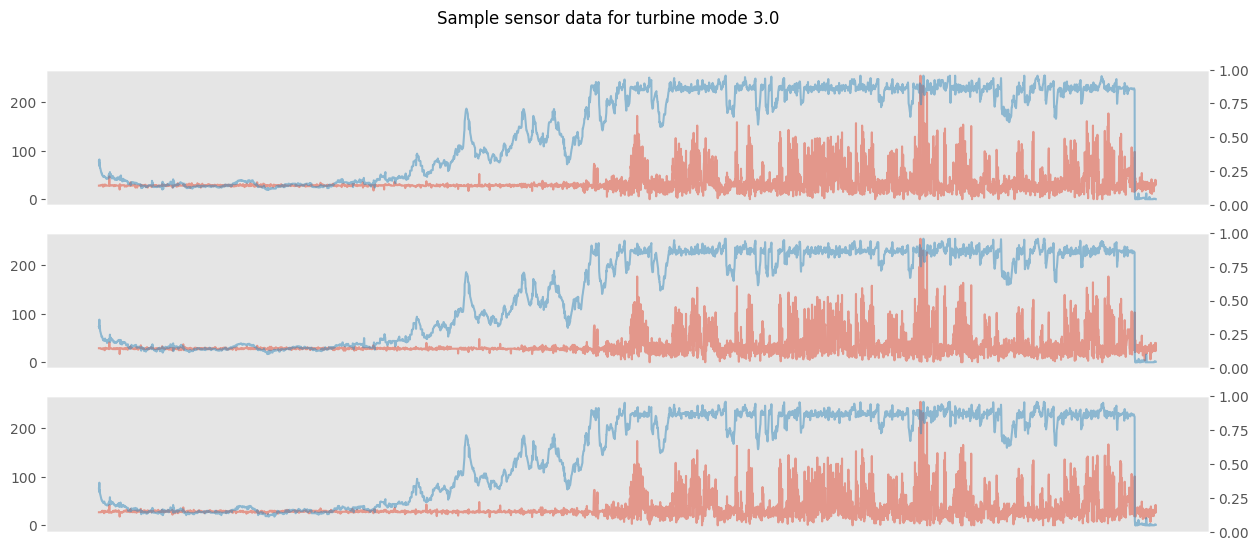

In [6]:
for turbine_mode in set(y):
    # Take the first 3 samples from each turbine mode
    sample_turbine_mode_indices = np.argwhere(y == turbine_mode)[:3].squeeze()

    fig, axs = plt.subplots(3, 1, figsize=(15, 6))
    fig.suptitle(f'Sample sensor data for turbine mode {turbine_mode}')

    for row_num, sample_turbine_mode_index in enumerate(sample_turbine_mode_indices):
        plot_data = X[sample_turbine_mode_index]
        
        ax_to_plot = axs[row_num]

        ax_to_plot.plot(plot_data[:, 0].squeeze(), alpha=0.5)
        ax_to_plot.twinx()
        ax_to_plot.plot(plot_data[:, 1].squeeze(), alpha=0.5)

        ax_to_plot.get_xaxis().set_visible(False)

    plt.show()

I appears that there is no noticeable difference between the sampled sensor data of the 4 modes. We could try and plot the average sensor data of each mode.

In [7]:
def plot_average_sensor_data(X):
    fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    for i, turbine_mode in enumerate(set(y)):
        turbine_mode_indices = np.argwhere(y == turbine_mode).squeeze()

        axs[i].set_title(f'Average sensor data for turbine mode {turbine_mode}')

        plot_data = X[turbine_mode_indices].mean(axis=0)

        axs[i].plot(plot_data[:, 0].squeeze(), alpha=.5)
        axs[i].twinx()
        axs[i].plot(plot_data[:, 1].squeeze(), alpha=.5)

    plt.show()


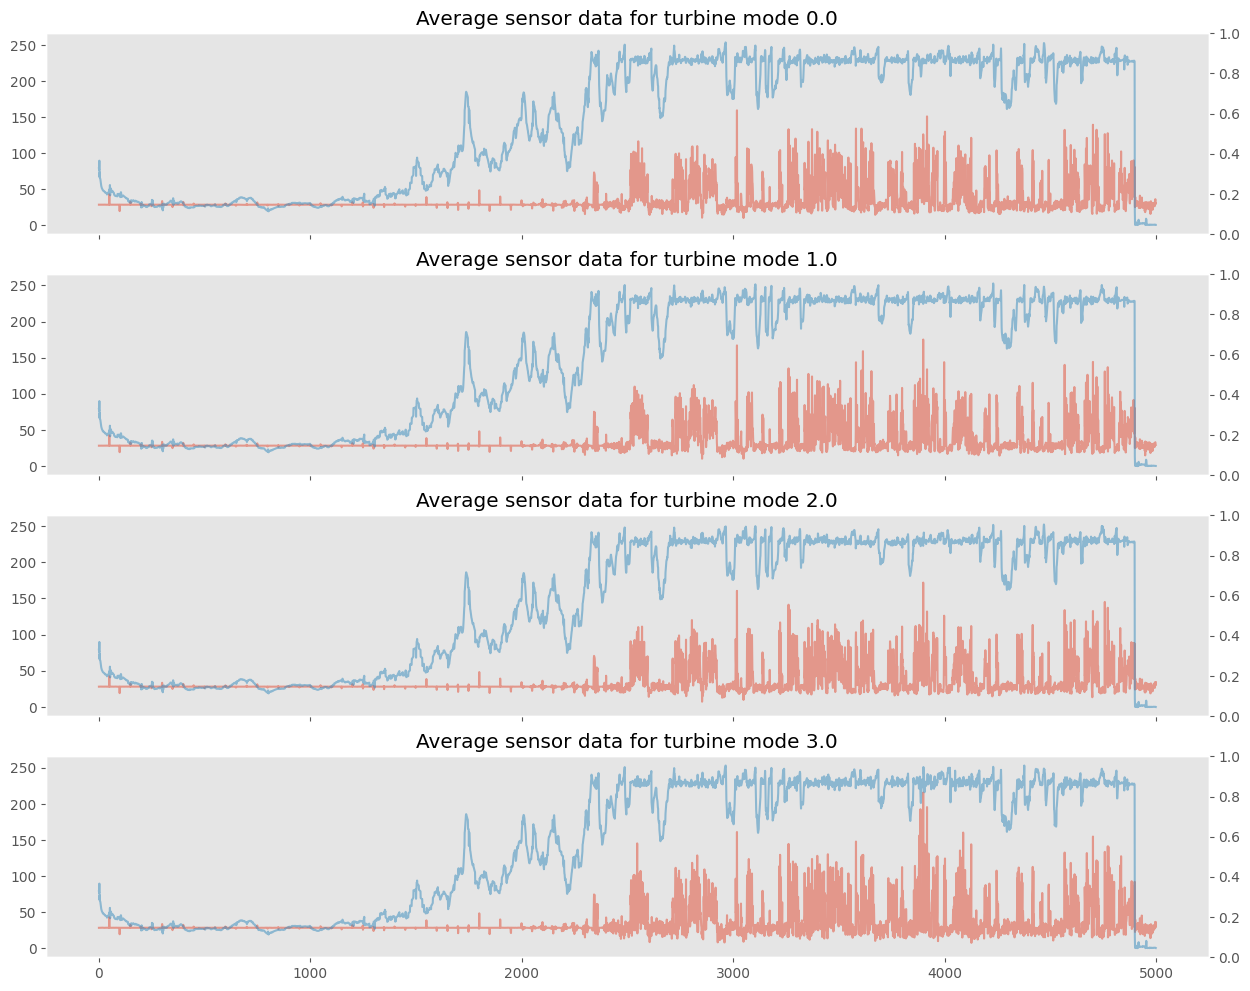

In [8]:
plot_average_sensor_data(X)

However, when we look at the average of each mode, there's something quite noticeable: Around the 3,800th timesteps, the red line spikes up and reaches the blue line for turbine mode 3. This pattern does not appear in the remaining turbine modes. Therefore, the differences between the readings of the 2 sensors may be useful here.

## 2.3. Visualising scaled data

In [9]:
print(stats.describe(np.vstack(X)))

DescribeResult(nobs=20000000, minmax=(array([0, 0], dtype=uint8), array([255, 255], dtype=uint8)), mean=array([ 34.72364305, 143.11656495]), variance=array([ 494.10723608, 7862.09026855]), skewness=array([ 2.99150686, -0.26584355]), kurtosis=array([11.89889674, -1.6850116 ]))


Overall, the reading of sensors appear to have the same lower and upper bounds, from 0 to 255. However, on average, the second sensor have much more variance and value than the first one. We can consider the second sensor to be on a different scale. Therefore, let's try to normalise them to 0 mean and unit variance for ease of analysis. However, when we get to the modelling stage, if we want to apply this technique, the scaling will only be fitted on the training set.

In [10]:
def normalise_data(X, scaler=None):
    # If no scaler is provided, create a scaler, then fit it to the data
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(X.reshape(-1, X.shape[2]))

    # Reshape the data to 2D for scaling, then reshape it back to its original shape
    normalise_data = scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
    
    return scaler, normalise_data

In [11]:
scaler, X_normalised = normalise_data(X)

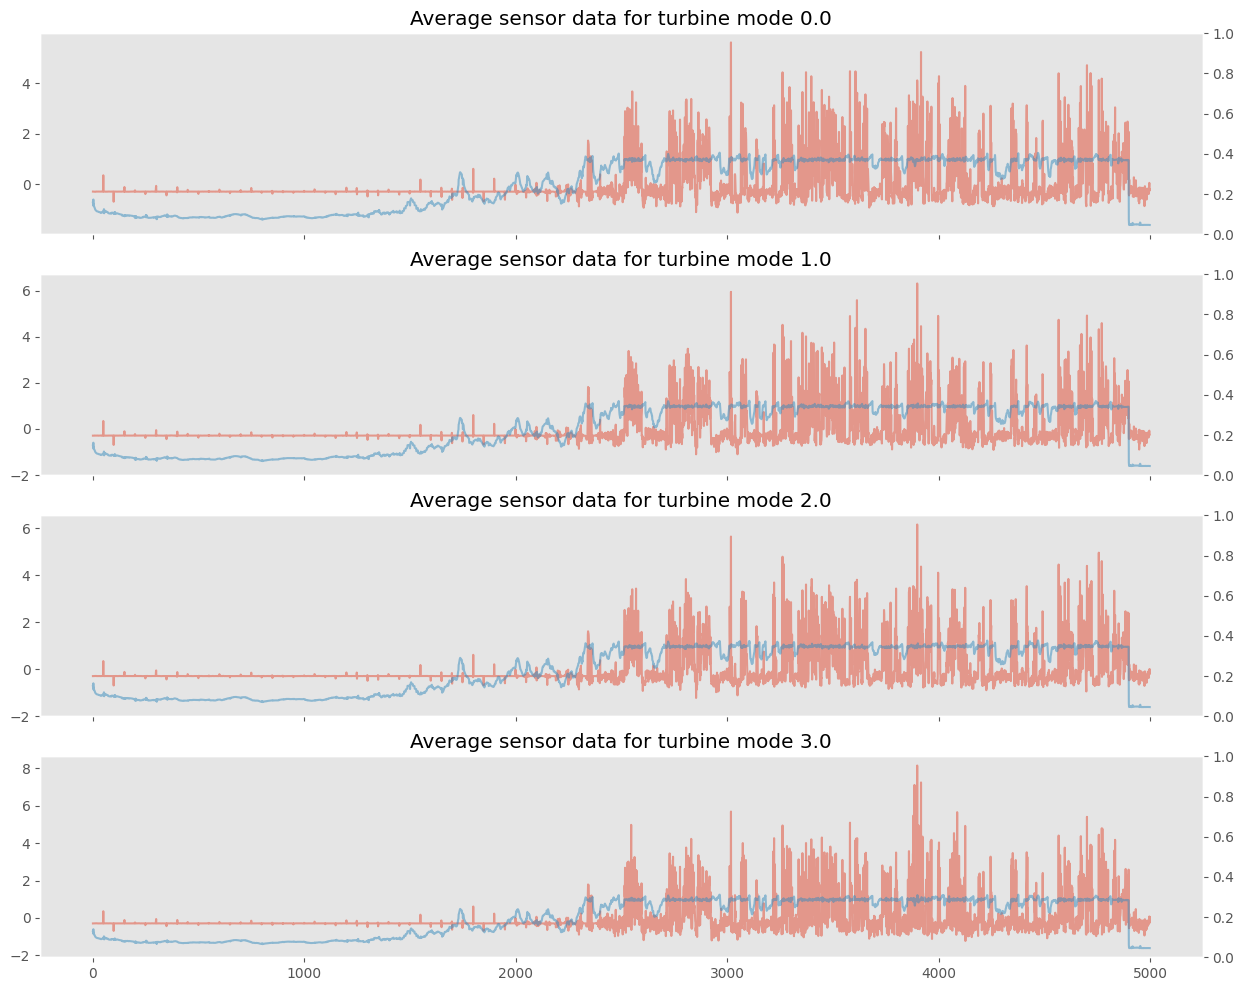

In [12]:
plot_average_sensor_data(X_normalised)

As discussed in the previous section, the difference between the readings from the two sensors may be indicative of the turbine mode (at least for the 4th mode). We will now analyse to see if there is any pattern in the difference.

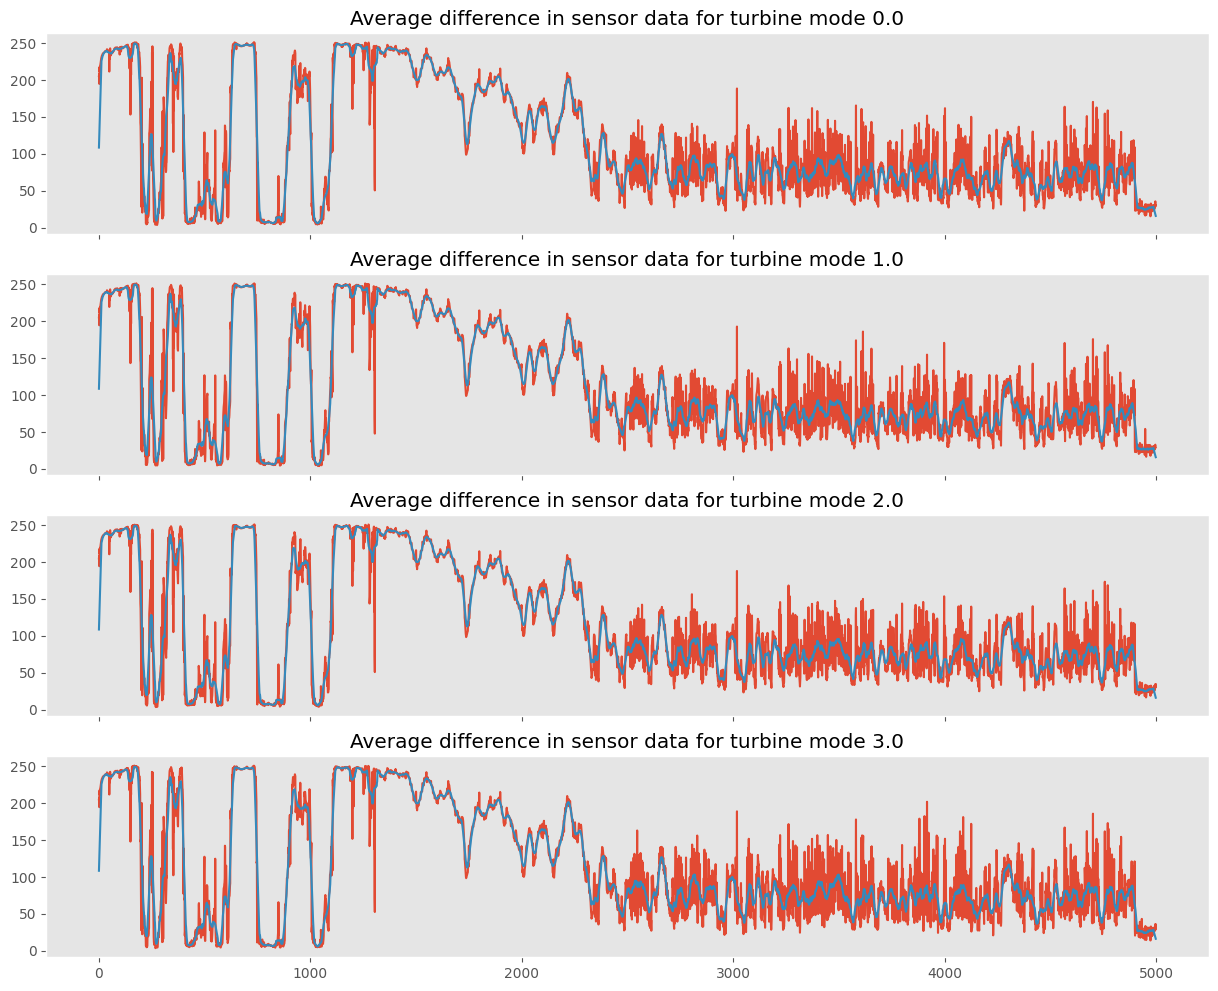

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

for i, turbine_mode in enumerate(set(y)):
    turbine_mode_indices = np.argwhere(y == turbine_mode).squeeze()

    sensor_data = X[turbine_mode_indices, :, :]
    
    plot_data = (sensor_data[:, :, 0] - sensor_data[:, :, 1]).mean(axis=0)

    axs[i].set_title(f'Average difference in sensor data for turbine mode {turbine_mode}')
    axs[i].plot(plot_data.squeeze())
    axs[i].plot(np.convolve(plot_data.squeeze(), np.ones(24) / 24, mode='same'))

plt.show()


In terms of the summary statistics for the scaled data:

In [14]:
for turbine_mode in set(y):
    turbine_mode_indices = np.argwhere(y == turbine_mode).flatten()

    sensor_data = X_normalised[turbine_mode_indices, :, :]

    # Add rate of change
    sensor_data = np.concatenate(
        [
            sensor_data,
            (sensor_data[:, :, 0] - sensor_data[:, :, 1])[..., np.newaxis],
        ],
        axis=2,
    )

    print(f'Summary statistic for turbine mode {turbine_mode}')
    print(stats.describe(np.vstack(sensor_data)))

Summary statistic for turbine mode 0.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.29065275])), mean=array([-1.36906311e-03, -3.12326507e-05, -1.33783045e-03]), variance=array([1.00356418, 0.99997435, 1.46111824]), skewness=array([ 3.02111839, -0.26575111,  0.34790822]), kurtosis=array([12.2643988 , -1.68523873,  1.39216469]))
Summary statistic for turbine mode 1.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.17787303])), mean=array([-0.00245772,  0.00163809, -0.00409581]), variance=array([1.00053517, 1.00297503, 1.4607519 ]), skewness=array([ 3.02892768, -0.26552219,  0.34254938]), kurtosis=array([12.21447021, -1.68566997,  1.28036494]))
Summary statistic for turbine mode 2.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.20042897])), mean=array([ 0.00044677, -0.0018547 

Analysing the scaled data does not provide better insights. In terms of the overall trend and summary statistics, there is no clear difference in sensor data across all 4 modes.

Another the aspect that these plots and statistics failed to capture is very subtle anomalies, as they will be averaged out, and they will not be visible when we look at the time series of 5,000 data points all at once. Therefore, we can propose the following hypotheses:

- Local patterns (e.g., the spikes) may be more important in classifying the turbine modes than global ones (e.g., overall trend, summary statistics).
- Anomalies that are very subtle and very hard to capture visually could be important in classifying the turbine modes.

Amongst the deep learning approaches, convolutional-based neural networks are very good for identifying these patterns and thus can be promising in this task.

# 3. Modelling

**Question 1**: Discuss what type of sequence prediction approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible to predict the operating mode of a turbine based on the two sensor reading time series. Also describe what data shape you need to use for your chosen approach.

**Answer**:

- **sequence-to-vector**: This is a natural choice - We are dealing with a time series classification problems. We have 4000 sequences that matches to 4000 operating modes.
- **sequence-to-sequence**: This is suitable when the output can be a sequence (e.g., time series), or when there is some dependency between the operating modes. However in our case, there is no time information so we won't be able to connect these 4000 operating modes. We can treat them as independent. Also, each sequence has a length of 5000, and we only have one label for the whole sequence, so won't be able to model this as a seq-to-seq problem. Finally, we do not know if the sequences are ordered and hence it would be risky to make such assumption.
- **encoder-decoder**: This works best for translation tasks, or when output is not a scalar, which makes this approach not suitable for our problem.

To follow the sequence-to-vector approach, the data needs to be reshaped as follows:
- input: `(n_batches, batch_size, n_timesteps, n_features)`.
- Output: `(n_batches, batch_size, )`. 

In our case, if the batch size is 64 and the sequences are passed in without further processing, the input shape for each batch would be `(64, 5000, 2)` and the output shape would be `(64, )`

**Question 2**: Create an iterator (ideally, a tensorflow.data.Dataset) that produces batches of data formatted in the appropriate way for your chosen approach.

In [15]:
def scale_data(X):
    # Scale the data from 0-255 to 0-1
    return X / 255.0

In [16]:
# Perform a 80-10-10 train-val-test split
X_train, X_other, y_train, y_other = train_test_split(scale_data(X), y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, stratify=y_other, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3200, 5000, 2) (400, 5000, 2) (400, 5000, 2)


In [17]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(10)
    .batch(64)
    .prefetch(1)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(64)
    .prefetch(1)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(64)
    .prefetch(1)
)

In [18]:
# Check if the dataset shape is as expected
list(train_dataset.as_numpy_iterator())[0][0].shape

(64, 5000, 2)

In [19]:
def train_model(model, train_dataset, val_dataset, test_dataset):
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_path / model.name, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    ]

    history = model.fit(
        train_dataset,
        epochs=100,
        validation_data=val_dataset,
        callbacks=callbacks,
    )

    # Plot performance
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['loss'], label="Training")
    axs[0].plot(history.history['val_loss'], label="Validation")
    axs[0].set_title('Loss (categorical cross entropy)')
    axs[1].plot(history.history['accuracy'], label="Training")
    axs[1].plot(history.history['val_accuracy'], label="Validation")
    axs[1].set_title('Accuracy')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Load the best model
    model = tf.keras.models.load_model(model_path / model.name)

    # Evaluate
    print('Train performance')
    train_loss, train_accuracy = model.evaluate(train_dataset)
    print('Val performance')
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print('Test performance')
    test_loss, test_accuracy = model.evaluate(test_dataset)

    return model, (model.name, train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)


In [20]:
# Initiate an empty list to store all results. We'll later convert this to a pandas
# dataframe to compare the results
all_metrics = []

## 3.1. Baselines

Before investing time in developing a neural network, it is useful to establish some baselines:

- Random prediction: Since we have an even split between all turbines modes, predicting randomly (or predicting only one turbine mode) can gives us 25% accuracy.
- Build a multi-class logistic regression to predict the turbine mode based on the summary statistics: This approach may not be significantly better than random prediction because we have discovered that all 4 modes had similar summary statistics.
- Recurrent neural networks: We could include this method in for the sake of completeness and as a baseline. This is because these networks takes longer to train, and as noted in section 2, local patterns instead of sequential patterns could be indicative of the turbine modes. In addition, our sequence length is 5000 and therefore recurrent models will encounter difficulties learning such sequences.

In [23]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(128, input_shape=(None, X.shape[2])),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ],
    name='recurrent_gru_baseline'
)
model.summary()

Model: "recurrent_gru_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               50688     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 59,204
Trainable params: 59,204
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.3869 - accuracy: 0.2503

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 36s 381ms/step - loss: 1.3869 - accuracy: 0.2503 - val_loss: 1.3855 - val_accuracy: 0.2500
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 1.3858 - accuracy: 0.2731

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 363ms/step - loss: 1.3858 - accuracy: 0.2731 - val_loss: 1.3840 - val_accuracy: 0.2575
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 1.3838 - accuracy: 0.2719

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 366ms/step - loss: 1.3838 - accuracy: 0.2719 - val_loss: 1.3801 - val_accuracy: 0.3350
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.2975

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 354ms/step - loss: 1.3792 - accuracy: 0.2975 - val_loss: 1.3735 - val_accuracy: 0.2650
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 1.3691 - accuracy: 0.3041

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 365ms/step - loss: 1.3691 - accuracy: 0.3041 - val_loss: 1.3571 - val_accuracy: 0.3100
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 1.3490 - accuracy: 0.3338

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 359ms/step - loss: 1.3490 - accuracy: 0.3338 - val_loss: 1.3313 - val_accuracy: 0.4175
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 1.3226 - accuracy: 0.3684

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 358ms/step - loss: 1.3226 - accuracy: 0.3684 - val_loss: 1.3029 - val_accuracy: 0.3900
Epoch 8/100
50/50 [==============================] - ETA: 0s - loss: 1.2905 - accuracy: 0.3925

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 363ms/step - loss: 1.2905 - accuracy: 0.3925 - val_loss: 1.2105 - val_accuracy: 0.4225
Epoch 9/100
50/50 [==============================] - ETA: 0s - loss: 1.2405 - accuracy: 0.4341

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 359ms/step - loss: 1.2405 - accuracy: 0.4341 - val_loss: 1.2013 - val_accuracy: 0.4275
Epoch 10/100
50/50 [==============================] - 14s 285ms/step - loss: 1.2338 - accuracy: 0.4253 - val_loss: 1.2949 - val_accuracy: 0.3725
Epoch 11/100
50/50 [==============================] - ETA: 0s - loss: 1.2384 - accuracy: 0.4294

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 19s 372ms/step - loss: 1.2384 - accuracy: 0.4294 - val_loss: 1.1499 - val_accuracy: 0.4675
Epoch 12/100
50/50 [==============================] - ETA: 0s - loss: 1.1459 - accuracy: 0.4806

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 364ms/step - loss: 1.1459 - accuracy: 0.4806 - val_loss: 1.1242 - val_accuracy: 0.5000
Epoch 13/100
50/50 [==============================] - ETA: 0s - loss: 1.1316 - accuracy: 0.4888

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 19s 372ms/step - loss: 1.1316 - accuracy: 0.4888 - val_loss: 1.1154 - val_accuracy: 0.5075
Epoch 14/100
50/50 [==============================] - ETA: 0s - loss: 1.1178 - accuracy: 0.5016

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 21s 420ms/step - loss: 1.1178 - accuracy: 0.5016 - val_loss: 1.1123 - val_accuracy: 0.4950
Epoch 15/100
50/50 [==============================] - 14s 283ms/step - loss: 1.1020 - accuracy: 0.4997 - val_loss: 1.1208 - val_accuracy: 0.5050
Epoch 16/100
50/50 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.5197

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 19s 376ms/step - loss: 1.0892 - accuracy: 0.5197 - val_loss: 1.0909 - val_accuracy: 0.5100
Epoch 17/100
50/50 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.5272

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 361ms/step - loss: 1.0830 - accuracy: 0.5272 - val_loss: 1.0846 - val_accuracy: 0.5050
Epoch 18/100
50/50 [==============================] - ETA: 0s - loss: 1.0658 - accuracy: 0.5241

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 362ms/step - loss: 1.0658 - accuracy: 0.5241 - val_loss: 1.0432 - val_accuracy: 0.5325
Epoch 19/100
50/50 [==============================] - ETA: 0s - loss: 1.0512 - accuracy: 0.5300

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 361ms/step - loss: 1.0512 - accuracy: 0.5300 - val_loss: 1.0369 - val_accuracy: 0.5400
Epoch 20/100
50/50 [==============================] - ETA: 0s - loss: 1.0513 - accuracy: 0.5269

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 362ms/step - loss: 1.0513 - accuracy: 0.5269 - val_loss: 1.0111 - val_accuracy: 0.5475
Epoch 21/100
50/50 [==============================] - 15s 292ms/step - loss: 1.0247 - accuracy: 0.5425 - val_loss: 1.0124 - val_accuracy: 0.5500
Epoch 22/100
50/50 [==============================] - ETA: 0s - loss: 1.0076 - accuracy: 0.5547

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 19s 381ms/step - loss: 1.0076 - accuracy: 0.5547 - val_loss: 0.9981 - val_accuracy: 0.5675
Epoch 23/100
50/50 [==============================] - 15s 291ms/step - loss: 1.0068 - accuracy: 0.5578 - val_loss: 1.1303 - val_accuracy: 0.4625
Epoch 24/100
50/50 [==============================] - ETA: 0s - loss: 1.0624 - accuracy: 0.5109

INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


INFO:tensorflow:Assets written to: models\recurrent_gru_baseline\assets


50/50 [==============================] - 18s 365ms/step - loss: 1.0624 - accuracy: 0.5109 - val_loss: 0.9773 - val_accuracy: 0.5725
Epoch 25/100
50/50 [==============================] - 14s 285ms/step - loss: 1.1016 - accuracy: 0.4875 - val_loss: 1.1698 - val_accuracy: 0.4375
Epoch 26/100
50/50 [==============================] - 14s 288ms/step - loss: nan - accuracy: 0.3613 - val_loss: nan - val_accuracy: 0.2500
Epoch 27/100
50/50 [==============================] - 14s 290ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 28/100
50/50 [==============================] - 15s 291ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 29/100
50/50 [==============================] - 14s 281ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 30/100
50/50 [==============================] - 14s 288ms/step - loss: nan - accuracy: 0.2500 - val_loss: nan - val_accuracy: 0.2500
Epoch 31/100
50/50 [========

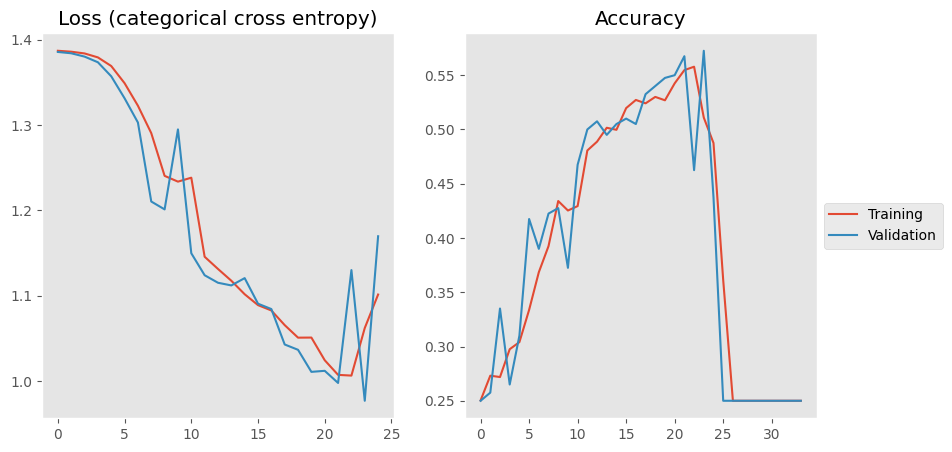

Train performance
50/50 [==============================] - 7s 121ms/step - loss: 0.9672 - accuracy: 0.5722
Val performance
7/7 [==============================] - 1s 116ms/step - loss: 0.9773 - accuracy: 0.5725
Test performance
7/7 [==============================] - 1s 117ms/step - loss: 0.9959 - accuracy: 0.5475


In [24]:
model, metrics = train_model(model, train_dataset, val_dataset, test_dataset)
all_metrics.append(metrics)

## 3.2. Main approach

### 3.2.1. Conv1D-based network

**Question 3**: Create a neural network in TensorFlow to predict the operating mode of a wind turbine based on the sensor data. Make sure that you try out different layers and elements discussed in class, such as Dense, SimpleRNN, GRU, and Conv1D.

**Answer:**

As a starting point, we create a simple neural network with a Conv1D layer as hidden layer. We do have the option of using a `GlobalAveragePooling1D` layer after the conv1D instead of a `Flatten` layer, but since we only have 64 filters of Conv1D of size 6, the number of parameters is still quite small, so averaging may result in too much information loss and is not totally necessary.

In [25]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Conv1D(64, 6, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ],
    name='conv1d_base'
)
model.summary()

Model: "conv1d_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4995, 64)          832       
                                                                 
 flatten (Flatten)           (None, 319680)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 1278724   
                                                                 
Total params: 1,279,556
Trainable params: 1,279,556
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.6218 - accuracy: 0.4591

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 14s 71ms/step - loss: 2.6218 - accuracy: 0.4591 - val_loss: 0.6385 - val_accuracy: 0.8650
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8855

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 3s 59ms/step - loss: 0.3750 - accuracy: 0.8856 - val_loss: 0.2774 - val_accuracy: 0.9050
Epoch 3/100
50/50 [==============================] - 2s 37ms/step - loss: 0.2600 - accuracy: 0.8884 - val_loss: 0.2776 - val_accuracy: 0.8975
Epoch 4/100
49/50 [============================>.] - ETA: 0s - loss: 0.2402 - accuracy: 0.8960

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 3s 62ms/step - loss: 0.2407 - accuracy: 0.8959 - val_loss: 0.2453 - val_accuracy: 0.9050
Epoch 5/100
49/50 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.9002

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 3s 67ms/step - loss: 0.2330 - accuracy: 0.9000 - val_loss: 0.2434 - val_accuracy: 0.9050
Epoch 6/100
49/50 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9034

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 4s 71ms/step - loss: 0.2239 - accuracy: 0.9031 - val_loss: 0.2382 - val_accuracy: 0.9050
Epoch 7/100
49/50 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9037

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 4s 87ms/step - loss: 0.2208 - accuracy: 0.9031 - val_loss: 0.2372 - val_accuracy: 0.9050
Epoch 8/100
50/50 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9041

INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 [==============================] - 3s 69ms/step - loss: 0.2146 - accuracy: 0.9041 - val_loss: 0.2368 - val_accuracy: 0.9050
Epoch 9/100
50/50 [==============================] - 2s 38ms/step - loss: 0.2101 - accuracy: 0.9081 - val_loss: 0.2380 - val_accuracy: 0.9050
Epoch 10/100
50/50 [==============================] - 2s 40ms/step - loss: 0.2069 - accuracy: 0.9066 - val_loss: 0.2438 - val_accuracy: 0.9050
Epoch 11/100
50/50 [==============================] - 2s 39ms/step - loss: 0.2035 - accuracy: 0.9119 - val_loss: 0.2403 - val_accuracy: 0.9050
Epoch 12/100
50/50 [==============================] - 2s 37ms/step - loss: 0.1983 - accuracy: 0.9106 - val_loss: 0.2370 - val_accuracy: 0.9050
Epoch 13/100
50/50 [==============================] - 2s 37ms/step - loss: 0.1930 - accuracy: 0.9134 - val_loss: 0.2451 - val_accuracy: 0.9050
Epoch 14/100
50/50 [==============================] - 2s 38ms/step - loss: 0.1914 - accuracy: 0.9175 - val_loss: 0.2440 - val_accuracy: 0.9075
Epoch 15/100


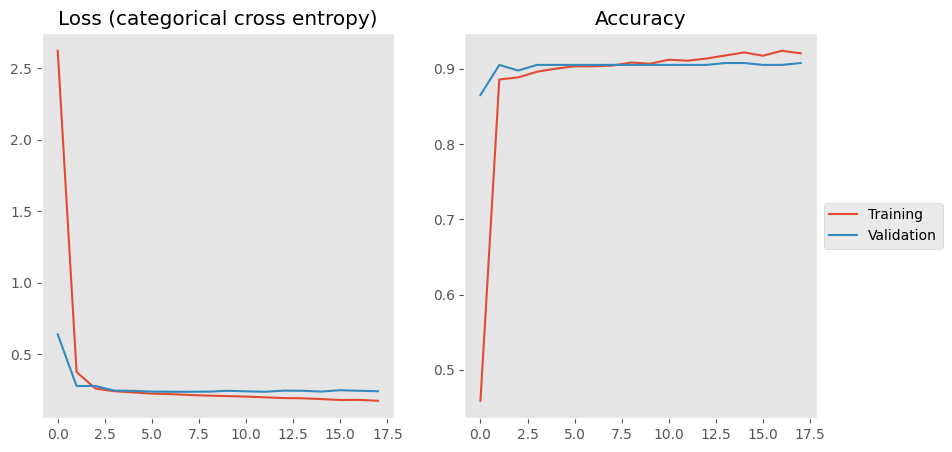

Train performance
50/50 [==============================] - 1s 19ms/step - loss: 0.2078 - accuracy: 0.9019
Val performance
7/7 [==============================] - 0s 17ms/step - loss: 0.2368 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 17ms/step - loss: 0.2797 - accuracy: 0.8900


In [26]:
model, metrics = train_model(model, train_dataset, val_dataset, test_dataset)
all_metrics.append(metrics)

The model is started overfitting after the 10th epochs. Interestingly, after only 2 to 3 epochs, the training accuracy was still increasing but validation accuracy has stopped improving. This is understandable as this is a relatively simple model with no regularisation implemented. However, we have well surpassed the baseline of 25% accuracy and the recurrent model's performance.

In [27]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Conv1D(64, 6, padding='same'),
        tf.keras.layers.Conv1D(64, 6, padding='same'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(32, 6, padding='same'),
        tf.keras.layers.MaxPool1D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv1d_regularised'
)
model.summary()

Model: "conv1d_improved"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5000, 64)          832       
                                                                 
 conv1d_2 (Conv1D)           (None, 5000, 64)          24640     
                                                                 
 dropout (Dropout)           (None, 5000, 64)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 5000, 32)          12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4998, 32)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 159936)            0         
                                                   

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.5002 - accuracy: 0.3081

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 11s 184ms/step - loss: 2.5002 - accuracy: 0.3081 - val_loss: 3.4433 - val_accuracy: 0.2500
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.9439 - accuracy: 0.6775

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 177ms/step - loss: 0.9439 - accuracy: 0.6775 - val_loss: 1.1940 - val_accuracy: 0.3600
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8925

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 171ms/step - loss: 0.4279 - accuracy: 0.8925 - val_loss: 0.3670 - val_accuracy: 0.9050
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8981

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 174ms/step - loss: 0.2687 - accuracy: 0.8981 - val_loss: 0.3219 - val_accuracy: 0.9050
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.8994

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 173ms/step - loss: 0.2395 - accuracy: 0.8994 - val_loss: 0.3005 - val_accuracy: 0.9025
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.8991

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 179ms/step - loss: 0.2348 - accuracy: 0.8991 - val_loss: 0.2975 - val_accuracy: 0.8975
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9019

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 180ms/step - loss: 0.2256 - accuracy: 0.9019 - val_loss: 0.2885 - val_accuracy: 0.9000
Epoch 8/100
50/50 [==============================] - 7s 149ms/step - loss: 0.2257 - accuracy: 0.8969 - val_loss: 0.2885 - val_accuracy: 0.8900
Epoch 9/100
50/50 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9003

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 177ms/step - loss: 0.2182 - accuracy: 0.9003 - val_loss: 0.2828 - val_accuracy: 0.8925
Epoch 10/100
50/50 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9003

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 183ms/step - loss: 0.2183 - accuracy: 0.9003 - val_loss: 0.2784 - val_accuracy: 0.8925
Epoch 11/100
50/50 [==============================] - 8s 152ms/step - loss: 0.2156 - accuracy: 0.9006 - val_loss: 0.2898 - val_accuracy: 0.8925
Epoch 12/100
50/50 [==============================] - 8s 152ms/step - loss: 0.2115 - accuracy: 0.9013 - val_loss: 0.2871 - val_accuracy: 0.8900
Epoch 13/100
50/50 [==============================] - 7s 150ms/step - loss: 0.2069 - accuracy: 0.9047 - val_loss: 0.2841 - val_accuracy: 0.8850
Epoch 14/100
50/50 [==============================] - 8s 150ms/step - loss: 0.2021 - accuracy: 0.9047 - val_loss: 0.2954 - val_accuracy: 0.8925
Epoch 15/100
50/50 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9112

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 183ms/step - loss: 0.1983 - accuracy: 0.9112 - val_loss: 0.2750 - val_accuracy: 0.8975
Epoch 16/100
50/50 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9116

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 175ms/step - loss: 0.1914 - accuracy: 0.9116 - val_loss: 0.2737 - val_accuracy: 0.8900
Epoch 17/100
50/50 [==============================] - 7s 149ms/step - loss: 0.1898 - accuracy: 0.9134 - val_loss: 0.3008 - val_accuracy: 0.8950
Epoch 18/100
50/50 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9150

INFO:tensorflow:Assets written to: models\conv1d_improved\assets


INFO:tensorflow:Assets written to: models\conv1d_improved\assets


50/50 [==============================] - 9s 188ms/step - loss: 0.1887 - accuracy: 0.9150 - val_loss: 0.2725 - val_accuracy: 0.8925
Epoch 19/100
50/50 [==============================] - 8s 158ms/step - loss: 0.1754 - accuracy: 0.9225 - val_loss: 0.2951 - val_accuracy: 0.8925
Epoch 20/100
50/50 [==============================] - 8s 170ms/step - loss: 0.1761 - accuracy: 0.9159 - val_loss: 0.3000 - val_accuracy: 0.9025
Epoch 21/100
50/50 [==============================] - 8s 162ms/step - loss: 0.1597 - accuracy: 0.9287 - val_loss: 0.2990 - val_accuracy: 0.8950
Epoch 22/100
50/50 [==============================] - 8s 158ms/step - loss: 0.1682 - accuracy: 0.9275 - val_loss: 0.3198 - val_accuracy: 0.8875
Epoch 23/100
50/50 [==============================] - 8s 164ms/step - loss: 0.1561 - accuracy: 0.9344 - val_loss: 0.2969 - val_accuracy: 0.8925
Epoch 24/100
50/50 [==============================] - 8s 160ms/step - loss: 0.1414 - accuracy: 0.9391 - val_loss: 0.3641 - val_accuracy: 0.8925
Epoch

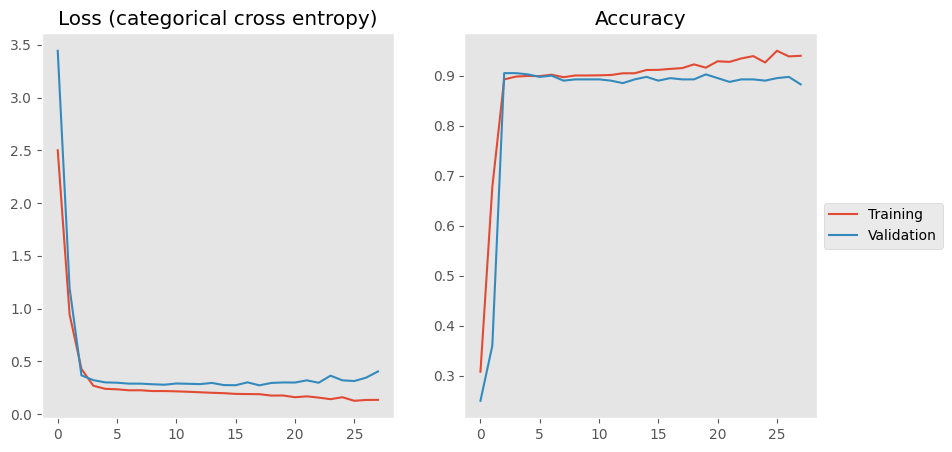

Train performance
50/50 [==============================] - 4s 52ms/step - loss: 0.1716 - accuracy: 0.9200
Val performance
7/7 [==============================] - 0s 44ms/step - loss: 0.2725 - accuracy: 0.8925
Test performance
7/7 [==============================] - 0s 44ms/step - loss: 0.3235 - accuracy: 0.8725


In [28]:
model, metrics = train_model(model, train_dataset, val_dataset, test_dataset)
all_metrics.append(metrics)

It appears that our 'base' model is a really hard baseline to beat! Adding more layers and regularisation did not improve the model.

**Question 4a:** We have come across Conv1D layers as a tool for analyzing time series. Different from recurrent layers such as SimpleRNN, LSTM, or GRU, when we apply a Conv1D layer to a part of a sequence, the operation does not depend on the application of the layer to previous parts of the sequence.

Discuss in which types of (business) applications Conv1D layers can be particularly useful, and in which you should prefer a recurrent layer. 

**Answer:** Convolutional layers in general are useful for problems where a sub-section of the data can be informative, regardless of its position. Therefore, Conv1D layers are useful in applications such as anomaly detection for time series, or time series classification (like this task) where each class can be determined by a local pattern, for example, sudden spikes in sensor readings can be attributed to faulty equipments. In contrast, recurrent layers are more suited for applications where the long-term, sequential dependency in data is important, for example, time series prediction, speech recognition. In our case, this could be relevant if the task is to predict the next `n` sensor readings, because the next sensor readings heavily depends on the previous readings.

In addition, since convolutional layers can be trained in parallel they are more suitable for applications involving a large volume of data, or long sequences, or with limited computing power than recurrent layers, which need to be trained sequentially. As a result, training convolutional models would take significantly less time.

Therefore, in this project, we will not experiment with reccurent models, as it would be extremely unlikely for them to outperform our models using Conv1D layers.

### 3.2.2. Conv2D

**Question 5:** Another, less frequently used tool for analyzing time-series data is convolutional neural networks with 2D convolutional layers. For this to work, time series need to be converted into “images” (matrices of numbers). The paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library) describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections 4 and 5 which depict the process of converting one or multiple time series into “images” used within a CNN.

In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs


**Answer:** Based on the insights in section 2 - Exploratory data analysis, there is very little to no difference in the overall trends of 4 turbine modes. Therefore, sequential models such as RNNs might not perform well. In contrast, convolutional layers can work really well in our problem because local pattern may provide strong signals for identifying the turbine modes (e.g., in section 2, around the 3,800th timesteps, the red line spikes up and reaches the blue line for turbine mode 3. This pattern does not appear in the remaining turbine modes.)

In the paper, the novelty is in the way the timeseries data are transformed into images - that is by dividing the time series (1 dimensional) into sequences of equal length and stack them vertically to construct a 2-dimensional array. This method may work really well for our problem, because there may be a cyclical pattern in the data. This is because the movement of the wind turbine blades are repetitive, which can produce cyclical data. Therefore, if the length of the sub-sequence are chosen carefully, the correlation between two adjacent elements in the 2D array could be very high for turbines operating in normal conditions.

For example, assuming we have a sensor that records the angle of a turbine blade in regular intervals, then the data it produces may be `120-240-360-120-240-360-120-240-360`. If the turbine functions normally, then we can expect the sub-sequence of `120-240-360` to repeat indefinitely. However, the angles of a mal-functioning turbine blade may be `120-242-360-120-241-360-120-239-360`. This difference is very subtle and would be impossible to notice visually. But if we follow the paper's approach by diving the data into sequences of length 3 and stacking them vertically, we will have the following:

- Healthy turbine:
```
| 120 | 240 | 360 |
| 120 | 240 | 360 |
| 120 | 240 | 360 |
```

- Mal-functioning turbine:
```
| 120 | 242 | 360 |
| 120 | 241 | 360 |
| 120 | 239 | 360 |
```

A 2D convolutional layer will be able to pick up the difference in the turbine blade's angles in the second column of the mal-functioning turbine's data.

For this to work, the sequence length will need to be tuned so that the correlation between two adjacent pixels are maximised. In cases where the length of the original time series is not divisble by the sequence length, it would be required to pad the last sequence to produce a rectangular image. However, in this paper, this was not performed - and the authors also clearly noted that
> "In addition, it is worth to mention that in CNN approaches, the information is extracted from the image by analysing the relationship between the adjacent
pixels. **However, in this paper, the adjacent pixels might not show any meaning.**".

Therefore, this technique may not yield a significant improvement over using 1D convolutions.

**Question 6:** Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image).

**Answer:**

In [29]:
def reshape_x(X):
    image_dim = int(np.sqrt(X.shape[1] * X.shape[2]))
    reshaped = np.concatenate(
        [
            X[:, :, 0].reshape(X.shape[0], image_dim, -1),
            X[:, :, 1].reshape(X.shape[0], image_dim, -1),
        ],
        axis=2
    )

    return reshaped[..., np.newaxis]

#### Test the reshaping function
Let's test our function on some dummy data

In [30]:
example_data = np.arange(1, 9)
example_sequence = np.array([
    example_data,
    example_data * 10,
]).T

example_sequences = np.array([example_sequence, example_sequence + .1, example_sequence + .2])
print(example_sequences.shape)
example_sequences

(3, 8, 2)


array([[[ 1. , 10. ],
        [ 2. , 20. ],
        [ 3. , 30. ],
        [ 4. , 40. ],
        [ 5. , 50. ],
        [ 6. , 60. ],
        [ 7. , 70. ],
        [ 8. , 80. ]],

       [[ 1.1, 10.1],
        [ 2.1, 20.1],
        [ 3.1, 30.1],
        [ 4.1, 40.1],
        [ 5.1, 50.1],
        [ 6.1, 60.1],
        [ 7.1, 70.1],
        [ 8.1, 80.1]],

       [[ 1.2, 10.2],
        [ 2.2, 20.2],
        [ 3.2, 30.2],
        [ 4.2, 40.2],
        [ 5.2, 50.2],
        [ 6.2, 60.2],
        [ 7.2, 70.2],
        [ 8.2, 80.2]]])

In [31]:
reshaped_exampled_sequences = reshape_x(example_sequences)
print(reshaped_exampled_sequences.shape)

reshaped_exampled_sequences[:, :, :, 0]

(3, 4, 4, 1)


array([[[ 1. ,  2. , 10. , 20. ],
        [ 3. ,  4. , 30. , 40. ],
        [ 5. ,  6. , 50. , 60. ],
        [ 7. ,  8. , 70. , 80. ]],

       [[ 1.1,  2.1, 10.1, 20.1],
        [ 3.1,  4.1, 30.1, 40.1],
        [ 5.1,  6.1, 50.1, 60.1],
        [ 7.1,  8.1, 70.1, 80.1]],

       [[ 1.2,  2.2, 10.2, 20.2],
        [ 3.2,  4.2, 30.2, 40.2],
        [ 5.2,  6.2, 50.2, 60.2],
        [ 7.2,  8.2, 70.2, 80.2]]])

It appears that the function is working as expected

#### Data preprocessing

In [32]:
# Scale data
X_train_2d = reshape_x(X_train)
X_val_2d = reshape_x(X_val)
X_test_2d = reshape_x(X_test)

print(X_train_2d.shape, X_val_2d.shape, X_test_2d.shape)

(3200, 100, 100, 1) (400, 100, 100, 1) (400, 100, 100, 1)


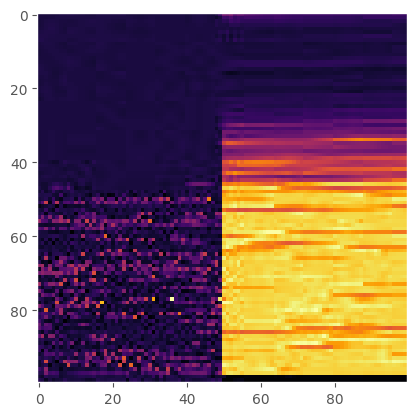

In [33]:
plt.imshow(X_train_2d[0], cmap='inferno')

In [34]:
train_dataset_2d = (
    tf.data.Dataset.from_tensor_slices((X_train_2d, y_train))
    .shuffle(10)
    .batch(64)
    .prefetch(1)
)

val_dataset_2d = (
    tf.data.Dataset.from_tensor_slices((X_val_2d, y_val))
    .batch(64)
    .prefetch(1)
)

test_dataset_2d = (
    tf.data.Dataset.from_tensor_slices((X_test_2d, y_test))
    .batch(64)
    .prefetch(1)
)

#### 3.2.2.1. Replicate the architecture in the paper as is

**Question 7:** In TensorFlow, replicate the CNN with three convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy. Submit the trained final model chosen in task 7, as an .h5-file


**Answer:**

In [35]:
# Since the paper did not include any details regarding padding, and strides, we can
# assume it's same padding for convolutional layers and strides=1 for the max pooling layer.
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(100, 100, 1)),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv2d_base'
)
model.summary()

Model: "conv2d_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 dropout_1 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 153664)            0         
                                                       

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.8227 - accuracy: 0.2647

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 11s 142ms/step - loss: 1.8227 - accuracy: 0.2647 - val_loss: 1.3844 - val_accuracy: 0.2500
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 1.2454 - accuracy: 0.4841

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 6s 122ms/step - loss: 1.2454 - accuracy: 0.4841 - val_loss: 0.8665 - val_accuracy: 0.8725
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.8616

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 6s 125ms/step - loss: 0.4753 - accuracy: 0.8616 - val_loss: 0.2743 - val_accuracy: 0.9050
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.8956

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 7s 136ms/step - loss: 0.2586 - accuracy: 0.8956 - val_loss: 0.2514 - val_accuracy: 0.9050
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.8950

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 6s 125ms/step - loss: 0.2406 - accuracy: 0.8950 - val_loss: 0.2464 - val_accuracy: 0.9050
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.8981

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 6s 125ms/step - loss: 0.2359 - accuracy: 0.8981 - val_loss: 0.2431 - val_accuracy: 0.9050
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.8947

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 6s 122ms/step - loss: 0.2352 - accuracy: 0.8947 - val_loss: 0.2384 - val_accuracy: 0.9050
Epoch 8/100
50/50 [==============================] - 5s 99ms/step - loss: 0.2357 - accuracy: 0.8950 - val_loss: 0.2447 - val_accuracy: 0.8950
Epoch 9/100
50/50 [==============================] - 5s 99ms/step - loss: 0.2226 - accuracy: 0.8969 - val_loss: 0.2404 - val_accuracy: 0.9050
Epoch 10/100
50/50 [==============================] - 5s 100ms/step - loss: 0.2300 - accuracy: 0.8944 - val_loss: 0.2494 - val_accuracy: 0.8950
Epoch 11/100
50/50 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.8991

INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 [==============================] - 6s 128ms/step - loss: 0.2187 - accuracy: 0.8991 - val_loss: 0.2376 - val_accuracy: 0.9050
Epoch 12/100
50/50 [==============================] - 5s 103ms/step - loss: 0.2227 - accuracy: 0.8975 - val_loss: 0.2443 - val_accuracy: 0.9000
Epoch 13/100
50/50 [==============================] - 5s 101ms/step - loss: 0.2129 - accuracy: 0.9028 - val_loss: 0.2473 - val_accuracy: 0.9050
Epoch 14/100
50/50 [==============================] - 5s 99ms/step - loss: 0.2175 - accuracy: 0.9009 - val_loss: 0.2453 - val_accuracy: 0.9050
Epoch 15/100
50/50 [==============================] - 5s 99ms/step - loss: 0.2103 - accuracy: 0.9019 - val_loss: 0.2408 - val_accuracy: 0.9050
Epoch 16/100
50/50 [==============================] - 5s 98ms/step - loss: 0.2110 - accuracy: 0.9062 - val_loss: 0.2419 - val_accuracy: 0.9025
Epoch 17/100
50/50 [==============================] - 5s 98ms/step - loss: 0.2086 - accuracy: 0.9078 - val_loss: 0.2484 - val_accuracy: 0.8925
Epoch 18/

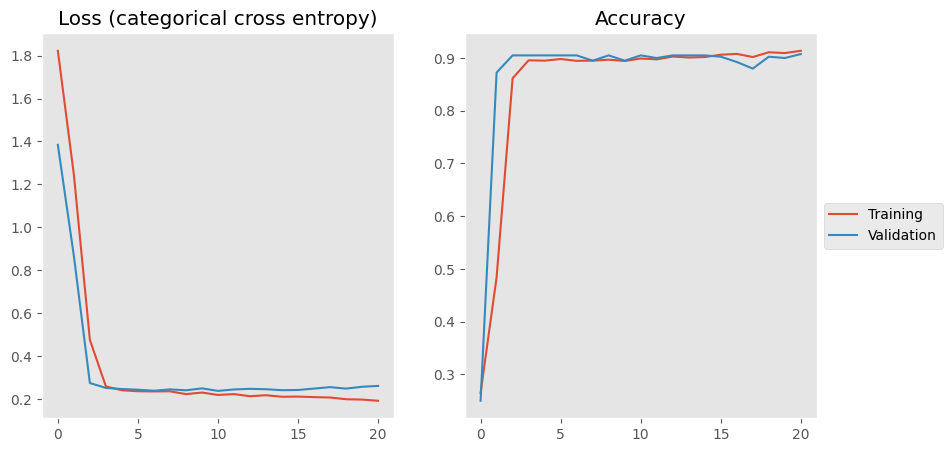

Train performance
50/50 [==============================] - 2s 30ms/step - loss: 0.2055 - accuracy: 0.9047
Val performance
7/7 [==============================] - 0s 27ms/step - loss: 0.2376 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 27ms/step - loss: 0.2765 - accuracy: 0.8850


In [36]:
model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

In [37]:
model.save(model_path / 'model_conv2d.h5')

#### 3.2.2.2. Tuning the replicated CNN

**Question 8:** Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.

**Answer:** In this section, we will consider the following approaches:
1. Using the most complex CNN architecture proposed in the paper
2. Adding more hidden layers to the fully-connected part
3. Tune the configuration of the existing layers of the current network
4. Using transfer learning

##### **Approach 1: Using the most complex CNN architecture proposed in the paper**

In section 5, the authors introduced a slightly more complex CNN architecture with more layers, which yielded the best performance when there are 4 sensors. We will see if the proposed architecture can yields a better accuracy for our task which only has 2 sensors.

In [38]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(100, 100, 1)),
        tf.keras.layers.Conv2D(128, 3, padding='same'),
        tf.keras.layers.Conv2D(64, 3, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(13, 3, padding='same'),
        tf.keras.layers.MaxPool2D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv2d_complex'
)
model.summary()

Model: "conv2d_complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     1280      
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      73792     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      18464     
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 13)      3757      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 13)       0         
 2D)                                                             
                                                    

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.8683 - accuracy: 0.2541

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 19s 338ms/step - loss: 1.8683 - accuracy: 0.2541 - val_loss: 1.3865 - val_accuracy: 0.2500
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 1.3660 - accuracy: 0.3141

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 17s 344ms/step - loss: 1.3660 - accuracy: 0.3141 - val_loss: 1.2330 - val_accuracy: 0.4625
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.7703

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 16s 330ms/step - loss: 0.6461 - accuracy: 0.7703 - val_loss: 0.3317 - val_accuracy: 0.9050
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.8903

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 16s 325ms/step - loss: 0.2752 - accuracy: 0.8903 - val_loss: 0.2644 - val_accuracy: 0.9050
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.8900

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 16s 322ms/step - loss: 0.2450 - accuracy: 0.8900 - val_loss: 0.2590 - val_accuracy: 0.9000
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8884

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 16s 324ms/step - loss: 0.2390 - accuracy: 0.8884 - val_loss: 0.2532 - val_accuracy: 0.9050
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.8928

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 [==============================] - 17s 331ms/step - loss: 0.2303 - accuracy: 0.8928 - val_loss: 0.2517 - val_accuracy: 0.8975
Epoch 8/100
50/50 [==============================] - 15s 292ms/step - loss: 0.2264 - accuracy: 0.8991 - val_loss: 0.2522 - val_accuracy: 0.9000
Epoch 9/100
50/50 [==============================] - 15s 293ms/step - loss: 0.2278 - accuracy: 0.8950 - val_loss: 0.2610 - val_accuracy: 0.9025
Epoch 10/100
50/50 [==============================] - 15s 296ms/step - loss: 0.2248 - accuracy: 0.8972 - val_loss: 0.2618 - val_accuracy: 0.9025
Epoch 11/100
50/50 [==============================] - 15s 301ms/step - loss: 0.2240 - accuracy: 0.8997 - val_loss: 0.2682 - val_accuracy: 0.9000
Epoch 12/100
50/50 [==============================] - 15s 300ms/step - loss: 0.2241 - accuracy: 0.8988 - val_loss: 0.2616 - val_accuracy: 0.9000
Epoch 13/100
50/50 [==============================] - 15s 298ms/step - loss: 0.2207 - accuracy: 0.9003 - val_loss: 0.2629 - val_accuracy: 0.9000


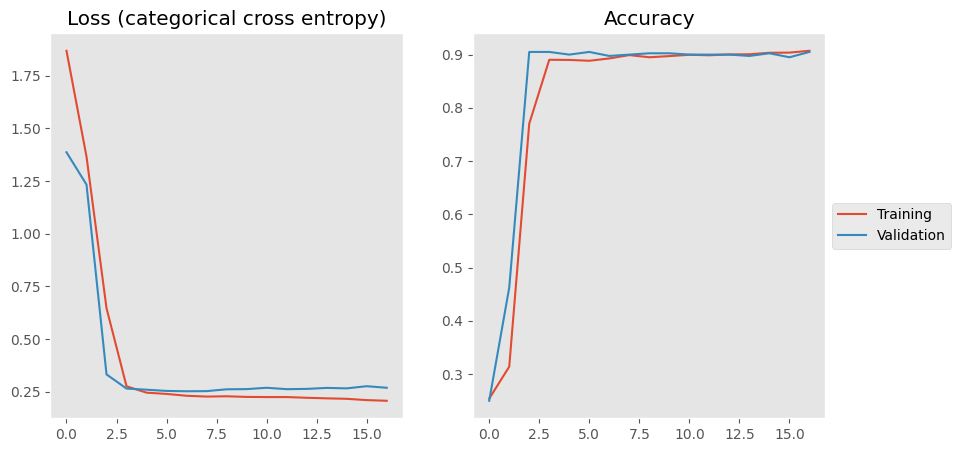

Train performance
50/50 [==============================] - 4s 77ms/step - loss: 0.2184 - accuracy: 0.9016
Val performance
7/7 [==============================] - 1s 69ms/step - loss: 0.2517 - accuracy: 0.8975
Test performance
7/7 [==============================] - 1s 68ms/step - loss: 0.2914 - accuracy: 0.8875


In [39]:
model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

##### **Approach 2: Adding more hidden layers to the fully-connected part**

So far, we have focused on improving the convolutional layers which performed feature extraction, which did not yield better performance. Therefore, it would be reasonable to explore improving the classification layer.

In [40]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(100, 100, 1)),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv2d_FC'
)
model.summary()

Model: "conv2d_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 dropout_3 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 98, 98, 16)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 153664)            0         
                                                         

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.9408 - accuracy: 0.3812

INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 [==============================] - 26s 500ms/step - loss: 1.9408 - accuracy: 0.3812 - val_loss: 1.2083 - val_accuracy: 0.6800
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.8125

INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 [==============================] - 22s 405ms/step - loss: 0.5358 - accuracy: 0.8125 - val_loss: 0.2794 - val_accuracy: 0.9050
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8931

INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 [==============================] - 19s 376ms/step - loss: 0.2585 - accuracy: 0.8931 - val_loss: 0.2697 - val_accuracy: 0.9050
Epoch 4/100
50/50 [==============================] - 7s 141ms/step - loss: 0.2411 - accuracy: 0.8984 - val_loss: 0.2847 - val_accuracy: 0.9000
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.8975

INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 [==============================] - 19s 392ms/step - loss: 0.2348 - accuracy: 0.8975 - val_loss: 0.2457 - val_accuracy: 0.9050
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.8956

INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 [==============================] - 18s 360ms/step - loss: 0.2306 - accuracy: 0.8956 - val_loss: 0.2441 - val_accuracy: 0.9050
Epoch 7/100
50/50 [==============================] - 7s 143ms/step - loss: 0.2273 - accuracy: 0.8941 - val_loss: 0.2455 - val_accuracy: 0.9025
Epoch 8/100
50/50 [==============================] - 7s 143ms/step - loss: 0.2235 - accuracy: 0.8953 - val_loss: 0.2463 - val_accuracy: 0.9000
Epoch 9/100
50/50 [==============================] - 7s 142ms/step - loss: 0.2229 - accuracy: 0.9000 - val_loss: 0.2695 - val_accuracy: 0.8775
Epoch 10/100
50/50 [==============================] - 7s 142ms/step - loss: 0.2242 - accuracy: 0.8972 - val_loss: 0.2517 - val_accuracy: 0.8875
Epoch 11/100
50/50 [==============================] - 7s 142ms/step - loss: 0.2171 - accuracy: 0.8988 - val_loss: 0.2549 - val_accuracy: 0.8850
Epoch 12/100
50/50 [==============================] - 7s 142ms/step - loss: 0.2174 - accuracy: 0.9006 - val_loss: 0.2494 - val_accuracy: 0.9000
Epoch 1

INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 [==============================] - 19s 379ms/step - loss: 0.2138 - accuracy: 0.9031 - val_loss: 0.2368 - val_accuracy: 0.9050
Epoch 14/100
50/50 [==============================] - 7s 140ms/step - loss: 0.2116 - accuracy: 0.9009 - val_loss: 0.2525 - val_accuracy: 0.8875
Epoch 15/100
50/50 [==============================] - 7s 140ms/step - loss: 0.2093 - accuracy: 0.8994 - val_loss: 0.2589 - val_accuracy: 0.8825
Epoch 16/100
50/50 [==============================] - 7s 140ms/step - loss: 0.2095 - accuracy: 0.9025 - val_loss: 0.2554 - val_accuracy: 0.8950
Epoch 17/100
50/50 [==============================] - 7s 140ms/step - loss: 0.2075 - accuracy: 0.9038 - val_loss: 0.2485 - val_accuracy: 0.8950
Epoch 18/100
50/50 [==============================] - 7s 141ms/step - loss: 0.2058 - accuracy: 0.9038 - val_loss: 0.3113 - val_accuracy: 0.8775
Epoch 19/100
50/50 [==============================] - 7s 141ms/step - loss: 0.2045 - accuracy: 0.9019 - val_loss: 0.2517 - val_accuracy: 0.8925
Epoc

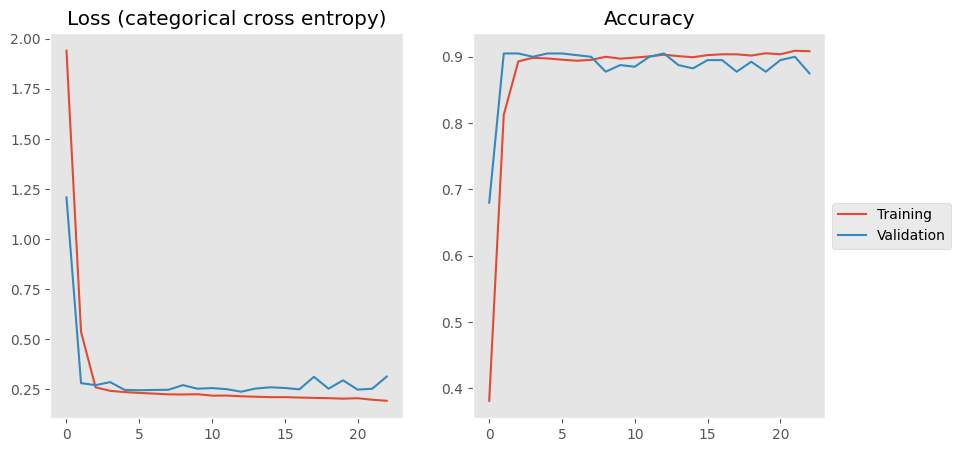

Train performance
50/50 [==============================] - 4s 33ms/step - loss: 0.2114 - accuracy: 0.9009
Val performance
7/7 [==============================] - 0s 30ms/step - loss: 0.2368 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 31ms/step - loss: 0.2742 - accuracy: 0.8850


In [41]:
model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

##### **Approach 3. Tune the configuration of the existing layers of the current network**

In [42]:
class HyperCNN2D(kt.HyperModel):
    def build(self, hp):
        # Parameters
        n_filters_conv1 = hp.Int('n_filters_conv1', min_value=32, max_value=128, step=4)
        n_filters_conv2 = hp.Int('n_filters_conv2', min_value=32, max_value=128, step=4)
        n_filters_conv3 = hp.Int('n_filters_conv3', min_value=16, max_value=64, step=4)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, sampling='linear')
        
        learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.01, sampling='log')

        model = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(100, 100, 1)),
                tf.keras.layers.Conv2D(n_filters_conv1, 3, padding='same'),
                tf.keras.layers.Conv2D(n_filters_conv2, 3, padding='same'),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Conv2D(n_filters_conv3, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPool2D(3, strides=1),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(4, activation='softmax'),
            ],
            name='conv2d_tuned'
        )

        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics = ['accuracy']
        )

        return model

tuner = kt.Hyperband(
    HyperCNN2D(),
    objective='val_loss',
    max_epochs=15, # We usually converged around the 10th epoch
    factor=3,
    seed=42,
    directory='./keras_tuning',
    project_name='hypercnn2d',
    overwrite=True,
)

tuner.search(
    train_dataset_2d,
    validation_data=(val_dataset_2d),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

Trial 27 Complete [00h 03m 48s]
val_loss: 1.386295199394226

Best val_loss So Far: 0.23131170868873596
Total elapsed time: 00h 28m 07s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [43]:
# Extract best hyperparameters
best_hyperparams = tuner.get_best_hyperparameters()[0]

print('-------- Best hyperparameters:')
for hyperparam_name, hyperparam_value in best_hyperparams.values.items():
    print(f'{hyperparam_name}: {hyperparam_value}')

-------- Best hyperparameters:
n_filters_conv1: 44
n_filters_conv2: 68
n_filters_conv3: 20
dropout_rate: 0.18146817896842063
learning_rate: 0.0012120499588457315
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 1.9667 - accuracy: 0.4209

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 12s 235ms/step - loss: 1.9667 - accuracy: 0.4209 - val_loss: 1.2161 - val_accuracy: 0.7900
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.8200

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 11s 230ms/step - loss: 0.6964 - accuracy: 0.8200 - val_loss: 0.3381 - val_accuracy: 0.9050
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8925

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 11s 230ms/step - loss: 0.2787 - accuracy: 0.8925 - val_loss: 0.2766 - val_accuracy: 0.9050
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8881

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 11s 230ms/step - loss: 0.2508 - accuracy: 0.8881 - val_loss: 0.2497 - val_accuracy: 0.9050
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.8938

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 11s 228ms/step - loss: 0.2422 - accuracy: 0.8938 - val_loss: 0.2434 - val_accuracy: 0.9100
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.8956

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 11s 230ms/step - loss: 0.2311 - accuracy: 0.8956 - val_loss: 0.2426 - val_accuracy: 0.9075
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.8981

INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 [==============================] - 12s 234ms/step - loss: 0.2294 - accuracy: 0.8981 - val_loss: 0.2424 - val_accuracy: 0.9050
Epoch 8/100
50/50 [==============================] - 10s 205ms/step - loss: 0.2261 - accuracy: 0.8981 - val_loss: 0.2465 - val_accuracy: 0.9025
Epoch 9/100
50/50 [==============================] - 10s 204ms/step - loss: 0.2237 - accuracy: 0.8975 - val_loss: 0.2458 - val_accuracy: 0.8975
Epoch 10/100
50/50 [==============================] - 10s 204ms/step - loss: 0.2214 - accuracy: 0.9006 - val_loss: 0.2444 - val_accuracy: 0.9025
Epoch 11/100
50/50 [==============================] - 10s 203ms/step - loss: 0.2164 - accuracy: 0.9003 - val_loss: 0.2434 - val_accuracy: 0.9050
Epoch 12/100
50/50 [==============================] - 10s 204ms/step - loss: 0.2168 - accuracy: 0.9019 - val_loss: 0.2453 - val_accuracy: 0.9000
Epoch 13/100
50/50 [==============================] - 10s 206ms/step - loss: 0.2145 - accuracy: 0.8978 - val_loss: 0.2450 - val_accuracy: 0.9050


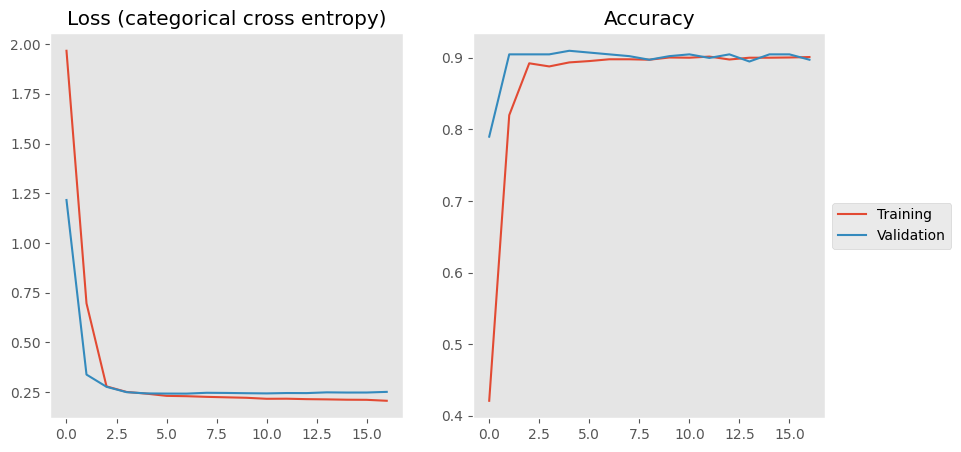

Train performance
50/50 [==============================] - 3s 56ms/step - loss: 0.2199 - accuracy: 0.9025
Val performance
7/7 [==============================] - 0s 50ms/step - loss: 0.2424 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 50ms/step - loss: 0.2851 - accuracy: 0.8750


In [44]:
model = tuner.hypermodel.build(best_hyperparams)

model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

##### **Approach 4: Using transfer learning**

We could consider the following options:
- Using pretrained model for the feature extraction layer: This is unlikely to yield better performance, because most image-based models are learned to extract feature from objects in images, which is completely different from the settings we have here (time series data reshaped into images). Therefore, the feature learned by these model are unlikely to be useful.
- Using the architecture of pretrained models: We have seen from the previous experiments that adding more complex structure did not meaningfully improved the model performance. In addition, these complex architecture were tuned for a very large dataset of images, which we do not have. Therefore, our dataset will not be able to fully utilise these architecture.

As a result, using transfer learning is not considered a suitable approach for our task.

# 4. Determining the best model

**Question 9:** Compare the models you have created so far and select the best model (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set. Make sure to record your final test accuracy.


**Answer:**

The following table summarises the model's performances:

In [45]:
pd.DataFrame(all_metrics, columns=['model_name', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'test_loss', 'test_accuracy'])

,model_name,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy
0,recurrent_gru_baseline,0.967186,0.572187,0.977289,0.5725,0.995943,0.5475
1,conv1d_base,0.207758,0.901875,0.236794,0.9050,0.279650,0.8900
2,conv1d_improved,0.171578,0.920000,0.272534,0.8925,0.323534,0.8725
3,conv2d_base,0.205497,0.904688,0.237643,0.9050,0.276488,0.8850
4,conv2d_complex,0.218416,0.901563,0.251663,0.8975,0.291419,0.8875
5,conv2d_FC,0.211434,0.900937,0.236818,0.9050,0.274232,0.8850
6,conv2d_tuned,0.219934,0.902500,0.242368,0.9050,0.285069,0.8750


Unsurprisingly, recurrent models performed poorly on this task, and Conv2D-based approach did not offer meaningful improvement over Conv1D-based models. Interestingly, all convolutional-based models achieved a similar level of performance, and adding more layers to the models did not significantly change their performance. In the paper, the authors achieved a 98% accuracy using the Conv2D approach, where are we've only achieved 89%, even though the data was processed the same way and the same model architectures were used. This could be because the dataset used in this project is not the same as that used in the paper. Further data quality may shed light on this.

Nevertheless, we can choose the `conv1d_base` model as our best model for the following reasons:
- It yields the best accuracy and losses, both on the validation and test sets
- It is the most simple and fastest to train
- It requires little data preprocessing
- In terms of model transparency, we can visualise the feature each convolutional filter captures to better understand the data. While this is also possible for the Conv2D-based approach, the vertical dimension does not carry any information (because the adjacent pixels are not correlated).

We can now train the model on the training and validation set, and evaluate on the test set.

In [46]:
train_val_dataset = train_dataset.concatenate(val_dataset)

In [47]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Conv1D(64, 6, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ],
    name='conv1d_base_train_val'
)
model.summary()

Model: "conv1d_base_train_val"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4995, 64)          832       
                                                                 
 flatten_2 (Flatten)         (None, 319680)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1278724   
                                                                 
Total params: 1,279,556
Trainable params: 1,279,556
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 1.7535 - accuracy: 0.5378

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 4s 58ms/step - loss: 1.7535 - accuracy: 0.5378 - val_loss: 0.7258 - val_accuracy: 0.6725
Epoch 2/100
55/57 [===========================>..] - ETA: 0s - loss: 0.3503 - accuracy: 0.8847

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 54ms/step - loss: 0.3503 - accuracy: 0.8847 - val_loss: 0.2941 - val_accuracy: 0.8875
Epoch 3/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2720 - accuracy: 0.8898

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 57ms/step - loss: 0.2727 - accuracy: 0.8897 - val_loss: 0.2721 - val_accuracy: 0.8850
Epoch 4/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2441 - accuracy: 0.8943

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 53ms/step - loss: 0.2445 - accuracy: 0.8942 - val_loss: 0.2665 - val_accuracy: 0.8725
Epoch 5/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2346 - accuracy: 0.8966

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 58ms/step - loss: 0.2349 - accuracy: 0.8964 - val_loss: 0.2606 - val_accuracy: 0.8775
Epoch 6/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2304 - accuracy: 0.8960

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 55ms/step - loss: 0.2306 - accuracy: 0.8958 - val_loss: 0.2582 - val_accuracy: 0.8750
Epoch 7/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2263 - accuracy: 0.8980

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 55ms/step - loss: 0.2263 - accuracy: 0.8978 - val_loss: 0.2567 - val_accuracy: 0.8750
Epoch 8/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2260 - accuracy: 0.8952

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 5s 93ms/step - loss: 0.2262 - accuracy: 0.8950 - val_loss: 0.2539 - val_accuracy: 0.8900
Epoch 9/100
57/57 [==============================] - 2s 36ms/step - loss: 0.2298 - accuracy: 0.8972 - val_loss: 0.2544 - val_accuracy: 0.8825
Epoch 10/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2236 - accuracy: 0.8983

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 53ms/step - loss: 0.2233 - accuracy: 0.8981 - val_loss: 0.2471 - val_accuracy: 0.8925
Epoch 11/100
57/57 [==============================] - 2s 37ms/step - loss: 0.2179 - accuracy: 0.8989 - val_loss: 0.2475 - val_accuracy: 0.8825
Epoch 12/100
57/57 [==============================] - 2s 37ms/step - loss: 0.2111 - accuracy: 0.9014 - val_loss: 0.2513 - val_accuracy: 0.8900
Epoch 13/100
57/57 [==============================] - 2s 36ms/step - loss: 0.2160 - accuracy: 0.8969 - val_loss: 0.2480 - val_accuracy: 0.8900
Epoch 14/100
57/57 [==============================] - 2s 37ms/step - loss: 0.2075 - accuracy: 0.8989 - val_loss: 0.2473 - val_accuracy: 0.8825
Epoch 15/100
57/57 [==============================] - 2s 37ms/step - loss: 0.2034 - accuracy: 0.9019 - val_loss: 0.2524 - val_accuracy: 0.8875
Epoch 16/100
55/57 [===========================>..] - ETA: 0s - loss: 0.2038 - accuracy: 0.9043

INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 [==============================] - 3s 58ms/step - loss: 0.2032 - accuracy: 0.9042 - val_loss: 0.2466 - val_accuracy: 0.8800
Epoch 17/100
57/57 [==============================] - 2s 37ms/step - loss: 0.1974 - accuracy: 0.9031 - val_loss: 0.2493 - val_accuracy: 0.8875
Epoch 18/100
57/57 [==============================] - 2s 36ms/step - loss: 0.2000 - accuracy: 0.9078 - val_loss: 0.2503 - val_accuracy: 0.8900
Epoch 19/100
57/57 [==============================] - 2s 36ms/step - loss: 0.1909 - accuracy: 0.9056 - val_loss: 0.2489 - val_accuracy: 0.8925
Epoch 20/100
57/57 [==============================] - 2s 37ms/step - loss: 0.1854 - accuracy: 0.9131 - val_loss: 0.2486 - val_accuracy: 0.8925
Epoch 21/100
57/57 [==============================] - 2s 36ms/step - loss: 0.1816 - accuracy: 0.9139 - val_loss: 0.2571 - val_accuracy: 0.8500
Epoch 22/100
57/57 [==============================] - 2s 36ms/step - loss: 0.1797 - accuracy: 0.9192 - val_loss: 0.2509 - val_accuracy: 0.8825
Epoch 23/100

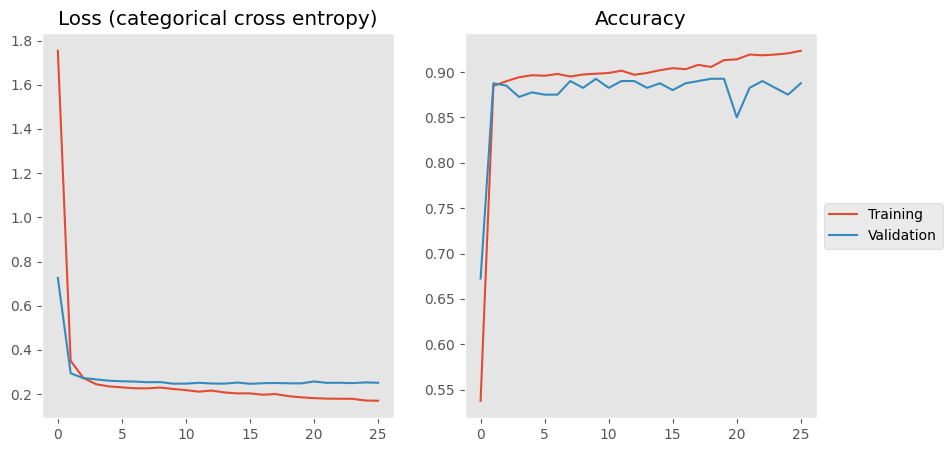

Train performance
57/57 [==============================] - 1s 20ms/step - loss: 0.1858 - accuracy: 0.9144
Val performance
7/7 [==============================] - 0s 18ms/step - loss: 0.2466 - accuracy: 0.8800
Test performance
7/7 [==============================] - 0s 18ms/step - loss: 0.2466 - accuracy: 0.8800


In [48]:
model, metrics = train_model(model, train_val_dataset, test_dataset, test_dataset)

In [50]:
pd.DataFrame([metrics], columns=['model_name', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'test_loss', 'test_accuracy'])

,model_name,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy
0,conv1d_base_train_val,0.185758,0.914444,0.246554,0.88,0.246554,0.88
